Классификация овощей с помощью Transfer Learning и заранее предобученной модели InceptionV3, которая уже обученная на датасете из более чем миллиона изображений(ImageNet).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from PIL import Image 
from PIL import ImageEnhance
from skimage.io import imread
import matplotlib.pyplot as plt

import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix

from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dense, Dropout

K.clear_session()

Задаю путь к датасету


In [ ]:
dataset='/content/drive/MyDrive/data/data_test'

train_folder = os.path.join(dataset,"train")
test_folder = os.path.join(dataset,"val")
validation_folder = os.path.join(dataset,"test")

Датасет разделен на тренировочные данные, валидационные и тестовые. В папке train 700 изображений, в val и test по 150 изображений. 

Средствами библиотеки matplotlib можно визуализировать изображения из любого класса на выбор.


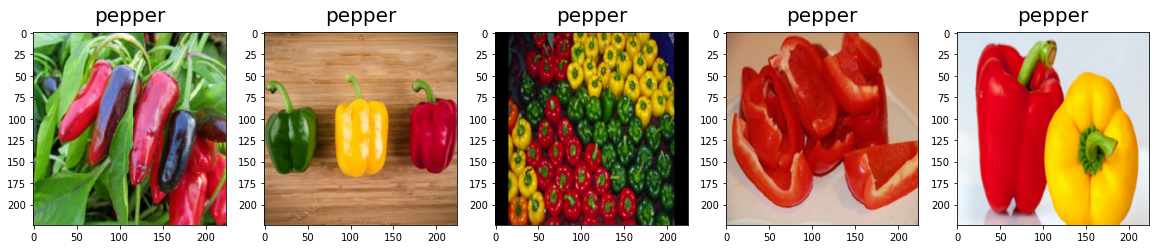

In [ ]:
select_vegetable="pepper"
rows,columns = 1,5

display_folder=os.path.join(train_folder,select_vegetable)
total_images=rows*columns
fig=plt.figure(1, figsize=(20, 10))

for i,j in enumerate(os.listdir(display_folder)):      
    
    img = plt.imread(os.path.join(train_folder,select_vegetable,j))
    fig=plt.subplot(rows, columns, i+1)
    fig.set_title(select_vegetable, pad = 11, size=20)
    plt.imshow(img)
    
    if i==total_images-1:
        break

Также можно рандомно выбрать изображение из каждого класса и визуализировать его.

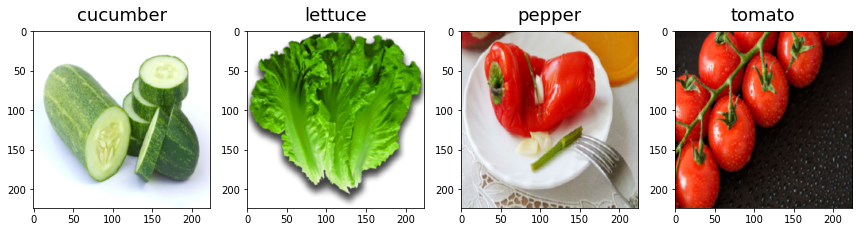

In [ ]:
images = []

for food_folder in sorted(os.listdir(train_folder)):
    food_items = os.listdir(train_folder + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_folder,food_folder,food_selected))
                                     
fig=plt.figure(1, figsize=(15, 10))

for subplot,image_ in enumerate(images):
    category=image_.split('/')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(3, 5, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)
    
plt.tight_layout()

Построение модели

In [ ]:
IMAGE_SIZE = [224, 224]

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='/content/drive/MyDrive/data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)

for layer in inception.layers:
    layer.trainable = False

x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=inception.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Тренировка модели с использованием ГПУ

In [ ]:
train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(
    train_folder,
    target_size = (224, 224),
    batch_size = 64,
    class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
    test_folder, 
    target_size = (224, 224),
    batch_size = 64, 
    class_mode = 'categorical')

Found 2800 images belonging to 4 classes.
Found 600 images belonging to 4 classes.


In [ ]:
class_map = training_set.class_indices
class_map

{'cucumber': 0, 'lettuce': 1, 'pepper': 2, 'tomato': 3}

In [ ]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
44/44 [==============================] - 43s 924ms/step - loss: 0.0314 - accuracy: 0.9907 - val_loss: 0.0241 - val_accuracy: 0.9950
Epoch 2/10
44/44 [==============================] - 40s 914ms/step - loss: 0.0263 - accuracy: 0.9914 - val_loss: 0.0305 - val_accuracy: 0.9950
Epoch 3/10
44/44 [==============================] - 41s 920ms/step - loss: 0.0250 - accuracy: 0.9918 - val_loss: 0.0295 - val_accuracy: 0.9950
Epoch 4/10
44/44 [==============================] - 41s 921ms/step - loss: 0.0325 - accuracy: 0.9914 - val_loss: 0.0509 - val_accuracy: 0.9833
Epoch 5/10
44/44 [==============================] - 40s 906ms/step - loss: 0.0386 - accuracy: 0.9871 - val_loss: 0.0279 - val_accuracy: 0.9917
Epoch 6/10
44/44 [==============================] - 40s 904ms/step - loss: 0.0228 - accuracy: 0.9911 - val_loss: 0.0289 - val_accuracy: 0.9917
Epoch 7/10
44/44 [==============================] - 40s 916ms/step - loss: 0.0147 - accuracy: 0.9943 - val_loss: 0.0239 - val_accuracy: 0.9950

Сохраняем модель


In [ ]:
model.save('/content/drive/MyDrive/data/saved_models/model_inceptionV3_epoch10.h5')

Построение графиков распотсранения ошибки(loss) и метрики accuracy(описывает общую точность предсказания модели по всем классам).

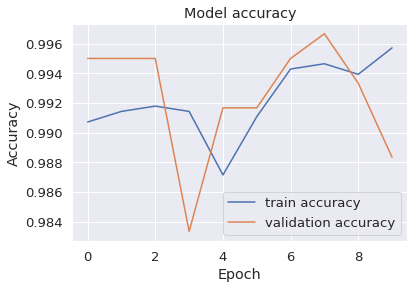

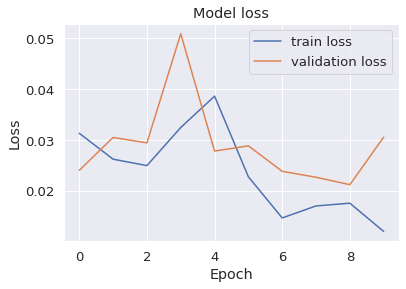

In [ ]:
def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()
    
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()
    
plot_accuracy(r)
plot_loss(r)

Загружаю обученную модель

In [ ]:
K.clear_session()
path_to_model='/content/drive/MyDrive/data/saved_models/model_inceptionV3_epoch10.h5'
model = load_model(path_to_model)

Loading the model..
Done!


Проверка модели на проверочном сете

In [ ]:
validation_data_dir = '/content/drive/MyDrive/data/data_test/test'

validation_datagen = image.ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical')

scores = model.evaluate_generator(validation_generator)
print("Test Accuracy: {:.3f}".format(scores[1]))

Found 600 images belonging to 4 classes.
Test Accuracy: 0.995


Функции для вывода прогноза модели

In [ ]:
category={0: 'cucumber', 1: 'lettuce', 2: 'pepper', 3 : 'tomato'}

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    prediction = model.predict(img_processed)
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(category[index]))
    plt.imshow(img_array)
    
def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1
    
    true=filedir.split('/')[-1]
    
    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))
        
    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)
        
        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,orignal=true))

Прогнозирование класса из естовой выборки на примере класса "cucumber"

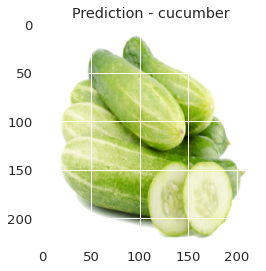

In [ ]:
predict_image(os.path.join(validation_folder,'cucumber/cucumber764.png'),model)

Прогноз точности из проверочной выборки

In [ ]:
for i in os.listdir(validation_folder):
    predict_dir(os.path.join(validation_folder,i),model)

Accuracy for pepper: 0.99 (148/150)
Accuracy for cucumber: 1.00 (150/150)
Accuracy for lettuce: 0.99 (149/150)
Accuracy for tomato: 1.00 (150/150)


Посмотрим на confusion matrix

In [ ]:
def labels_confusion_matrix(validation_folder):
    
    folder_path=validation_folder
    
    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i
    
    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):
        
        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]
        
        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(224,224))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0) 
            img_processed /= 255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)
            
    return (real,predicted)

def print_confusion_matrix(real,predicted):
    total_output_labels = 4
    cmap="Oranges"
    cm_plot_labels = [i for i in range(4)]
    
    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.2) # for label size
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap) # font size

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

Диагональные элементы представляют количество точек, для которых предсказанная метка равна истинной метке, а недиагональные элементы — это те, которые классификатор неправильно помечает. Чем выше диагональные значения матрицы, тем лучше, что указывает на множество правильных прогнозов

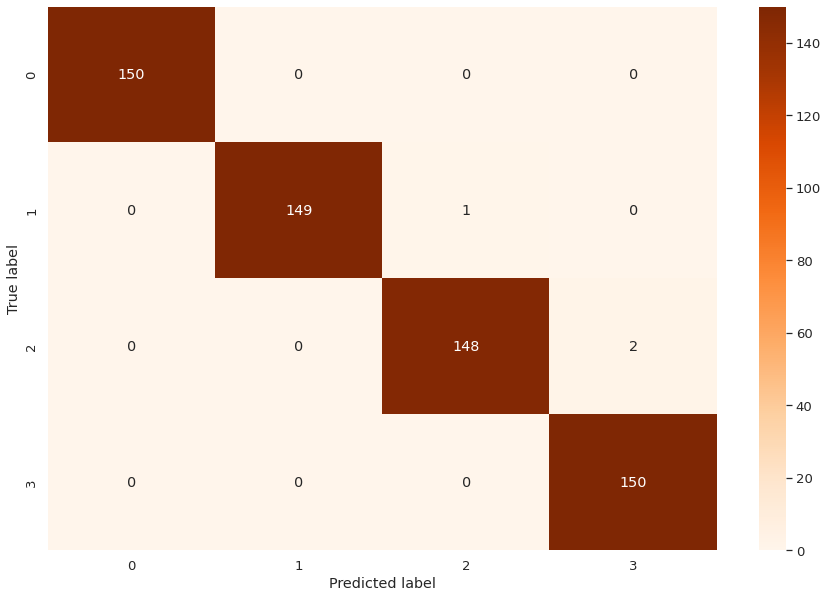

In [ ]:
y_true,y_pred=labels_confusion_matrix(validation_folder)
print_confusion_matrix(y_true,y_pred)

Визуализирую неправильные прогнозы

In [ ]:
def wrong_input_capture(test_category):
    
    a=os.path.basename(test_category)
    wrong_array=[]
    
    for i in os.listdir(test_category):
        
        imggg=os.path.join(test_category,i)
        
        img_ = image.load_img(imggg, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        
        index = np.argmax(prediction)
        pred=category.get(index)
        
        if not pred==a:
            wrong_array.append((imggg,pred))
            
    return wrong_array
    
def visualize_wrong_input(images):
    
    fig=plt.figure(1, figsize=(20, 25))
    total_images=len(images)
    rows=math.ceil(float(total_images/3))
    for subplot,(image_path,predicted) in enumerate(images):
        img = plt.imread(image_path)
        fig=plt.subplot(rows, 3, subplot+1)
        fig.set_title("Predicted - {}".format(predicted), pad = 10,size=18)
        plt.imshow(img)
        
    plt.tight_layout()

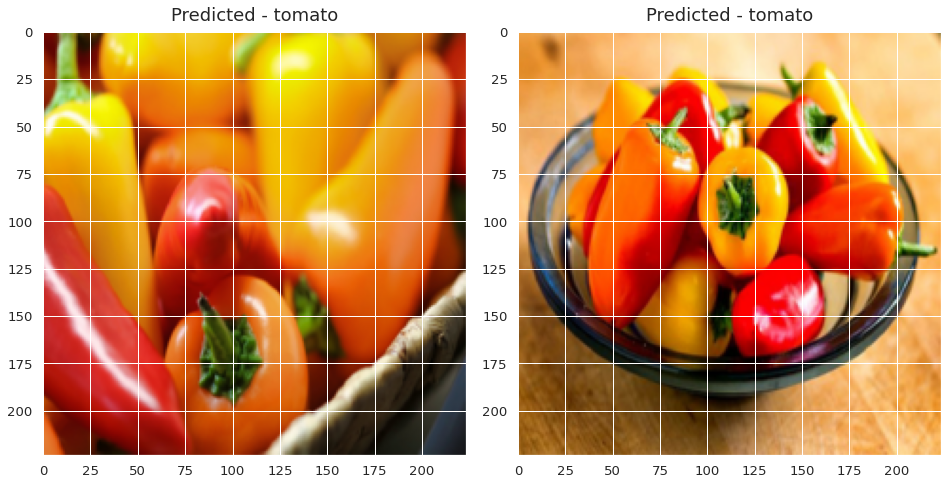

In [ ]:
vegetable="pepper"
path=os.path.join(validation_folder,vegetable)
images= wrong_input_capture(path)
visualize_wrong_input(images)